In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM as tp_lc_functions

In [2]:
# Using the 0D TNG100 SIM data at z=0 (version 5 of the dataset in this notebook, 
# for further explanation see Notebook v3 updated and v14)

df_0D = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v5_TNG-SIM_0D_Dataset.csv')
df_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v4_TNG-SIM_Raw_Dataset.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

df_0D.shape (21598, 16)
df_raw.shape (21598, 19)


### <font color='purple'> <a id =10> </a> <br> Take Log10 of all features and target, both 0D & raw

In [3]:
def log_df(df_init):
    
    df = df_init.copy()
    for feature in df.columns.to_list():
        if 'log' not in feature:
            df.loc[:, feature + '_log']=df.loc[:,feature].apply(lambda x: np.log10(x + 1.e-8))
            df.drop(columns = [feature], inplace = True)
#             print(df.loc[:, feature])
        else:continue
        
    return df

In [4]:
df_raw_log = log_df(df_raw)

In [5]:
df_raw_log.head(2)

,SubhaloBHMass_log,SubhaloBHMdot_log,SubhaloGasMetallicity_log,SubhaloSFRinRad_log,SubhaloStarMetallicity_log,SubhaloVelDisp_log,SubhaloVmax_log,SubhaloVmaxRad_log,SubhaloRgas_log,SubhaloRstar_log,SubhaloMgas_log,SubhaloMstar_log,GroupNsubs_log,Group_M_TopHat200_log,Group_R_TopHat200_log,SubhaloMHI_log,SubhaloMH2_log,Group_V_TopHat200_log,GroupSpin_dmo_log
0,9.998109,-3.400095,-2.112483,-0.708133,-1.543295,2.780947,2.999733,2.668073,2.949910,1.828096,13.092064,12.497443,4.235150,14.646987,3.292134,10.061858,10.043734,2.994161,-1.769689
1,9.898275,-4.012083,-2.359742,0.219496,-1.679031,2.774496,2.981978,3.134860,2.988572,2.098578,13.610459,12.316876,4.150971,14.687475,3.305635,9.899765,9.955786,3.007654,-1.893303


In [6]:
df_raw_log.shape

(21598, 19)

In [7]:
df_raw.shape

(21598, 19)

In [8]:
df_0D_log = log_df(df_0D)

In [9]:
df_0D_log.shape

(21598, 16)

In [10]:
df_0D.shape

(21598, 16)

### <font color='purple'> <a id =10> </a> <br> Complete Raw Dataset: SVR & Feature Ranking

In [11]:
df_raw_log.columns.to_list()

['SubhaloBHMass_log',
 'SubhaloBHMdot_log',
 'SubhaloGasMetallicity_log',
 'SubhaloSFRinRad_log',
 'SubhaloStarMetallicity_log',
 'SubhaloVelDisp_log',
 'SubhaloVmax_log',
 'SubhaloVmaxRad_log',
 'SubhaloRgas_log',
 'SubhaloRstar_log',
 'SubhaloMgas_log',
 'SubhaloMstar_log',
 'GroupNsubs_log',
 'Group_M_TopHat200_log',
 'Group_R_TopHat200_log',
 'SubhaloMHI_log',
 'SubhaloMH2_log',
 'Group_V_TopHat200_log',
 'GroupSpin_dmo_log']

In [12]:
X_all = df_raw_log.drop(columns=['SubhaloRstar_log'])
 

y_all = df_raw_log.loc[:,'SubhaloRstar_log']

In [14]:
# this code takes ~ 18 min to run it on the complete TNG-SIM dataset with ~22,000 galaxies 

start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svr__epsilon':[0.05,0.1,0.2],
              }


model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_all.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on TNG-SIM Raw Complete Dataset (optimizing epsilon too): {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best params, best score: 0.9013 {'svr__C': 10.0, 'svr__epsilon': 0.05, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM Raw Complete Dataset (optimizing epsilon too): 1086.987 seconds


#### Results of SVR when optimizing krenel, gamma and C
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best params, best score: 0.8941 {'svr__C': 10.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM Raw Complete Dataset: 182.750 seconds ~3min

#### Results of SVR when adding epsilon for optimization, together with krenel, gamma and C

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best params, best score: 0.9013 {'svr__C': 10.0, 'svr__epsilon': 0.05, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM Raw Complete Dataset (optimizing epsilon too): 1086.987 seconds

In [15]:
start_time = time.time()

best_SVR_all=model_all.best_estimator_

best_SVR_trainscore_all=model_all.cv_results_['mean_train_score'][model_all.best_index_]

scores_SVR_all = cross_val_score(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute this patch of code: {elapsed_time:.3f} seconds")

# It took 53 seconds ~ 1min to run this patch of code

Elapsed time to compute this patch of code: 52.535 seconds


In [16]:
start_time = time.time()

y_pred_SVR_all = cross_val_predict(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on Raw Complete Dataset: {elapsed_time:.3f} seconds")

# It took 54 seconds ~ 1min to run this patch of code

Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on Raw Complete Dataset: 50.351 seconds


In [10]:
# y_pred_SVR_df_all = pd.DataFrame({'y_pred_SVR SIM Raw': y_pred_SVR_all})

# y_pred_SVR_df_all.to_csv('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_y_pred_SVRwepsilon_predicted_sizes.csv', index=False)

y_pred_SVR_all = pd.read_csv('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_y_pred_SVRwepsilon_predicted_sizes.csv')

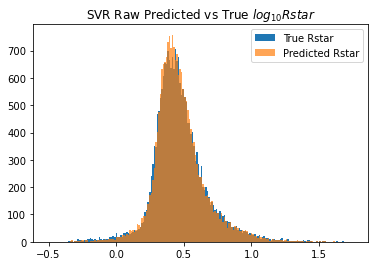

In [14]:
plt.hist(df_raw_log.SubhaloRstar_log, bins=200, label='True Rstar'
        , range=(-0.50, 1.75))
plt.hist(y_pred_SVR_all.loc[:, 'y_pred_SVR SIM Raw'], bins=200, alpha=0.7, label='Predicted Rstar'
        , range=(-0.50, 1.75))
plt.legend(loc='upper right')
plt.title(r'SVR Raw Predicted vs True $log_{10}Rstar$')
# plt.savefig('TNG-SIM_images/v16_SVR/v16_Histogram_SVR_pred_true_TNG-SIM_Raw_AllDatasetwMvir.jpeg', dpi=500)
plt.show()

In [18]:
best_SVR_trainscore_all

0.925940450403319

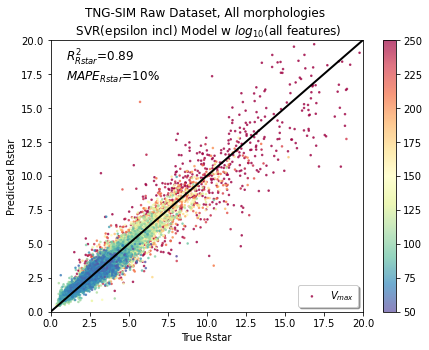

In [22]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_SVR_all),
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$', vmin=50, vmax=250)
ax.text(1.0, 17, r'$R^{2}_{Rstar}$=0.89' + '\n' + r'$MAPE_{Rstar}$=10$\%$ ', size=12)
ax.axis([0.0,20, 0.0,20])
ax.plot([0, 30], [0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, All morphologies \n ' + r'SVR(epsilon incl) Model w $log_{10}$(all features) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_SVRwepsilon_size_pred_colorVmaxVvir_2.jpeg', dpi=500)
plt.show()

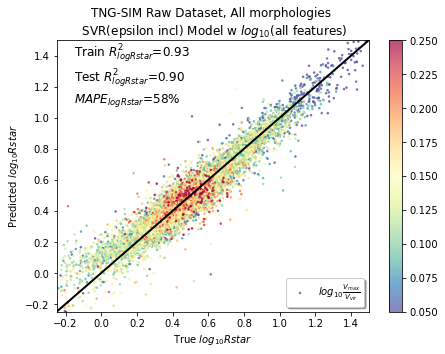

In [21]:
# Plot of Predicted log10 Raw Rstar vs True log 10 Raw Rstar

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw_log.SubhaloRstar_log, y_pred_SVR_all,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-0.15, 1.1, r'Train $R^{2}_{logRstar}$=0.93' + '\n' + r'Test $R^{2}_{logRstar}$=0.90' + '\n' + r'$MAPE_{logRstar}$=58$\%$ ', size=12)
ax.axis([-0.25,1.5, -0.25,1.5])
ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, All morphologies \n ' + r'SVR(epsilon incl) Model w $log_{10}$(all features) ')
ax.set_xlabel(r'True $log_{10}Rstar$')
ax.set_ylabel(r'Predicted $log_{10}Rstar$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_SVRwepsilon_size_pred_colorlogVmaxVvir_1.jpeg', dpi=500)
plt.show()

### Other metrics

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [20]:
print('MSE logRstar:', mean_squared_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))
print('sqrtMSE logRstar', np.sqrt(mean_squared_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw'])))
print('MAE logRstar', mean_absolute_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))
print('MAPE logRstar', # MAPE in log scale
mean_absolute_percentage_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))
print('r2 logRstar', # r2 score in log scale
r2_score(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))
print('Original MAPE Rstar', # MAPE in original variables
mean_absolute_percentage_error(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw'])))
print('Original r2 Rstar', # r2score in original variables
r2_score(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw'])))

MSE logRstar: 0.003946452835459114
sqrtMSE logRstar 0.06282079938570595
MAE logRstar 0.04563064940726768
MAPE logRstar 0.5797722652316809
r2 logRstar 0.9038046976956733
Original MAPE Rstar 0.10657972969348274
Original r2 Rstar 0.8930118084832459


### <font color='purple'> <a id =3> </a> <br> SVR Learning Curve

In [11]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    fig, ax = plt.subplots(figsize=(7, 5))
#     plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("# of training examples",fontsize = 14)
 
    ax.set_ylabel(r"$R^{2}$ score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    ax.legend(loc="best",fontsize = 12)
    return fig

Elapsed time to run SVR Learning Curves on the complete dataset: 29.557 seconds


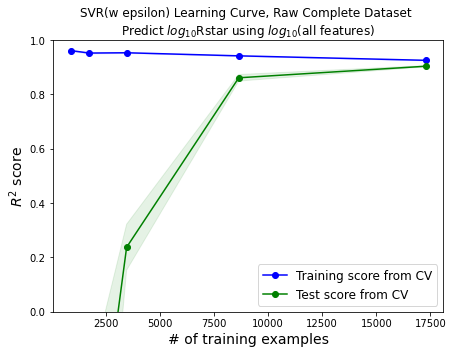

In [24]:
# this code takes ~2.5min to run on the whole dataset with ~22,000 galaxies
start_time = time.time()

lc_all = plot_learning_curve(best_SVR_all, 'SVR(w epsilon) Learning Curve, Raw Complete Dataset \n'+r'Predict $log_{10}$Rstar using $log_{10}$(all features)', X_all, y_all, ylim=(0.0, 1.0), train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

In [25]:
# lc_all.savefig('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_SVRwepsilon_Learning_Curve.jpeg', dpi=500)

### <font color='purple'> <a id =3> </a> <br> SVR Add-on Feature Ranking
   

In [12]:
def run_svr_search_pipeline(X, y):
    
    
    piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

    piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

    parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svr__epsilon':[0.05,0.1,0.2], 
                 }


    model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True, random_state=2024), \
                     verbose = 0, n_jobs = -1, return_train_score=True)

    model_all.fit(X, y)
    
    scores_lim = pd.DataFrame(model_all.cv_results_)

    scores_lim = scores_lim[['params','mean_test_score','std_test_score','mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)
    
    return scores_lim
#     return scores_lim['mean_test_score']

def calculate_r_score( X , y ,column_names):
    x_new = X[list(column_names)]
    # print(column_names)
    r_square = run_svr_search_pipeline(x_new, y)['mean_test_score']
    
    return r_square.max()


def print_results(max_col_names, max_col_rscores):
    k= 1
    for i, j in zip(max_col_names, max_col_rscores):
        print("\t", k, i,j)
        k +=1
        
def calc_ith_iteration( X, y, max_col_names, max_col_rscores, orj_column_names, i):
    r_score_dict = {}
    for column_names in tqdm(orj_column_names): # orj_column_names = original column names
        # count += 1
        # print(count, max_col_names , column_names)
        feature_list = max_col_names + [column_names]
        r_score = calculate_r_score(X , y ,feature_list)
        r_score_dict[column_names] = r_score
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))
    # print("asdfasd", max_col_names[len(max_col_names) - 1])
    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    return max_col_names, max_col_rscores, orj_column_names, r_score_dict

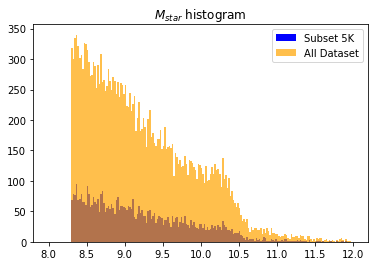

In [14]:
# choose a subsample of 10K galaxies since the original dataset is too large
df_raw_sample = df_raw_log.sample(n = 5000, random_state = 2023)

plt.hist(df_raw_sample.SubhaloMstar_log, 
         color='blue', label='Subset 5K', bins=200, range=(8.0,12))
plt.hist(df_raw_log.SubhaloMstar_log,  color='orange', 
         label='All Dataset', alpha=0.7, bins=200, range=(8.0,12))
plt.title(r'${M_{star}}$ histogram ')
plt.legend()
# plt.savefig('TNG300-paperSAM_images/v2/v2_BulgeMstar_ratio_histogram_all_vs_10kdataset_puredisks.jpeg', dpi=500)
plt.show()

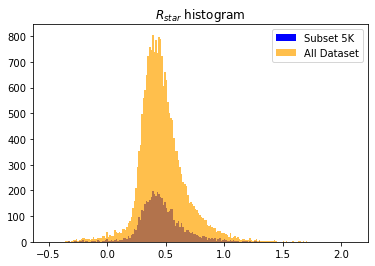

In [16]:
# choose a subsample of 10K galaxies since the original dataset is too large
df_raw_sample = df_raw_log.sample(n = 5000, random_state = 2023)

plt.hist(df_raw_sample.SubhaloRstar_log, 
         color='blue', label='Subset 5K', bins=200, range=(-0.5,2.1))
plt.hist(df_raw_log.SubhaloRstar_log,  color='orange', 
         label='All Dataset', alpha=0.7, bins=200, range=(-0.5,2.1))
plt.title(r'${R_{star}}$ histogram ')
plt.legend()
# plt.savefig('TNG300-paperSAM_images/v2/v2_BulgeMstar_ratio_histogram_all_vs_10kdataset_puredisks.jpeg', dpi=500)
plt.show()

  6%|██▎                                      | 1/18 [08:50<2:30:26, 530.98s/it]

	 1 SubhaloMH2_log 0.43990480444171115



 11%|████▍                                   | 2/18 [39:53<5:50:31, 1314.49s/it]

	 1 SubhaloMH2_log 0.43990480444171115
	 2 SubhaloMstar_log 0.5783222283152127



 17%|██████▎                               | 3/18 [1:28:17<8:30:03, 2040.22s/it]

	 1 SubhaloMH2_log 0.43990480444171115
	 2 SubhaloMstar_log 0.5783222283152127
	 3 SubhaloStarMetallicity_log 0.817645914360523



 22%|████████▍                             | 4/18 [2:02:17<7:55:57, 2039.84s/it]

	 1 SubhaloMH2_log 0.43990480444171115
	 2 SubhaloMstar_log 0.5783222283152127
	 3 SubhaloStarMetallicity_log 0.817645914360523
	 4 SubhaloSFRinRad_log 0.8408337069466012



 28%|██████████▌                           | 5/18 [2:25:13<6:30:07, 1800.55s/it]

	 1 SubhaloMH2_log 0.43990480444171115
	 2 SubhaloMstar_log 0.5783222283152127
	 3 SubhaloStarMetallicity_log 0.817645914360523
	 4 SubhaloSFRinRad_log 0.8408337069466012
	 5 SubhaloVmaxRad_log 0.8543261569000253



 33%|████████████▋                         | 6/18 [2:50:05<5:39:07, 1695.61s/it]

	 1 SubhaloMH2_log 0.43990480444171115
	 2 SubhaloMstar_log 0.5783222283152127
	 3 SubhaloStarMetallicity_log 0.817645914360523
	 4 SubhaloSFRinRad_log 0.8408337069466012
	 5 SubhaloVmaxRad_log 0.8543261569000253
	 6 SubhaloGasMetallicity_log 0.8652726065826922



 39%|██████████████▊                       | 7/18 [3:09:14<4:38:08, 1517.11s/it]

	 1 SubhaloMH2_log 0.43990480444171115
	 2 SubhaloMstar_log 0.5783222283152127
	 3 SubhaloStarMetallicity_log 0.817645914360523
	 4 SubhaloSFRinRad_log 0.8408337069466012
	 5 SubhaloVmaxRad_log 0.8543261569000253
	 6 SubhaloGasMetallicity_log 0.8652726065826922
	 7 SubhaloMgas_log 0.8737212907009398



 44%|████████████████▉                     | 8/18 [3:23:12<3:36:49, 1300.97s/it]

	 1 SubhaloMH2_log 0.43990480444171115
	 2 SubhaloMstar_log 0.5783222283152127
	 3 SubhaloStarMetallicity_log 0.817645914360523
	 4 SubhaloSFRinRad_log 0.8408337069466012
	 5 SubhaloVmaxRad_log 0.8543261569000253
	 6 SubhaloGasMetallicity_log 0.8652726065826922
	 7 SubhaloMgas_log 0.8737212907009398
	 8 SubhaloBHMass_log 0.8769244158274593



 50%|███████████████████                   | 9/18 [3:33:06<2:41:58, 1079.87s/it]

	 1 SubhaloMH2_log 0.43990480444171115
	 2 SubhaloMstar_log 0.5783222283152127
	 3 SubhaloStarMetallicity_log 0.817645914360523
	 4 SubhaloSFRinRad_log 0.8408337069466012
	 5 SubhaloVmaxRad_log 0.8543261569000253
	 6 SubhaloGasMetallicity_log 0.8652726065826922
	 7 SubhaloMgas_log 0.8737212907009398
	 8 SubhaloBHMass_log 0.8769244158274593
	 9 SubhaloVelDisp_log 0.8795864419675662



 50%|███████████████████                   | 9/18 [3:40:11<3:40:11, 1467.90s/it]

	 1 SubhaloMH2_log 0.43990480444171115
	 2 SubhaloMstar_log 0.5783222283152127
	 3 SubhaloStarMetallicity_log 0.817645914360523
	 4 SubhaloSFRinRad_log 0.8408337069466012
	 5 SubhaloVmaxRad_log 0.8543261569000253
	 6 SubhaloGasMetallicity_log 0.8652726065826922
	 7 SubhaloMgas_log 0.8737212907009398
	 8 SubhaloBHMass_log 0.8769244158274593
	 9 SubhaloVelDisp_log 0.8795864419675662
	 10 SubhaloRgas_log 0.8822395139512359


Text(0, 0.5, '$R^{2}$ score')

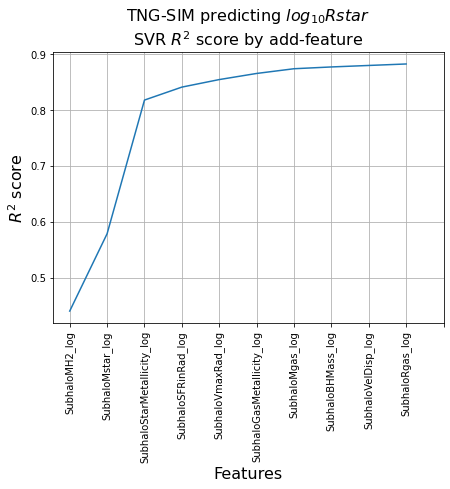

In [17]:
X_all = df_raw_sample.drop(columns=['SubhaloRstar_log'])
 

y_all = df_raw_sample.loc[:,'SubhaloRstar_log']

X = X_all
y = y_all

# Add-feature Ranking Method
# Note: This step calls 4 funcitons: run_random_search_pipeline(X,y), calculate_r_score(column_names),
# print_results(max_col_names, max_col_rscores), calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i)

column_names = X.columns


max_col_names = [] # 
max_col_rscores = []
orj_column_names = list(column_names)


# first loop - over all features  
for i in tqdm(range(1, len(orj_column_names)+1)):
#     max_col_names, max_col_rscores, orj_column_names, r_score_dict = calc_ith_iteration(X, y, max_col_names, max_col_rscores, orj_column_names, i)
    
    
    # second loop, using i selected features + each of the remaining features individually
    r_score_dict = {} # to store r_squares from second loop
    
    for column_name in tqdm(orj_column_names,miniters = 6,colour = 'red', leave = None): 
        
        feature_list = max_col_names + [column_name]

        r_square = run_svr_search_pipeline(X[feature_list], y)
        r_score_dict[column_name] = r_square['mean_test_score'].max()
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))

    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    print_results(max_col_names, max_col_rscores)
    
    if i==10: break # stop at 10th most important feature as I have observed that usually after the 7th feature R2 stabilizes

df_max_r_scores = pd.DataFrame({
    'feature_number' : range(1,11),
    'features':max_col_names,
    'r_sq_score': max_col_rscores  })
# Save the important feature ranking obtained by add-column method
#df_max_r_scores.to_csv('Max r scores by add column method.csv', index=False)

fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,11))
fig_add_feature.set_title(label= r'TNG-SIM predicting $log_{10}Rstar$' + '\n' + 'SVR $R^{2}$ score by add-feature',fontsize=16)
fig_add_feature.set_xlabel('Features',fontsize=16)
fig_add_feature.set_ylabel(r'$R^{2}$ score',fontsize=16)

In [18]:
# fig_add_feature.get_figure().savefig('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_SVR_R_score_by_add_feature.jpg', dpi=500)

# df_max_r_scores.to_csv('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_SVR_Max r scores by add column method.csv', index=False)


BEst 2 features from SVR with 21K galaxies. But this is taking far too long, so I will subsample only 5K and run SVR ranking there.

     1 SubhaloMH2_log 0.47920285948688807
	 2 SubhaloVmaxRad_log 0.6041635007122461
     
Feature ranking using a subsample of 5K galaxies (out of 21K available):

	 1 SubhaloMH2_log 0.43990480444171115
	 2 SubhaloMstar_log 0.5783222283152127
	 3 SubhaloStarMetallicity_log 0.817645914360523
	 4 SubhaloSFRinRad_log 0.8408337069466012
	 5 SubhaloVmaxRad_log 0.8543261569000253
	 6 SubhaloGasMetallicity_log 0.8652726065826922
	 7 SubhaloMgas_log 0.8737212907009398
	 8 SubhaloBHMass_log 0.8769244158274593
	 9 SubhaloVelDisp_log 0.8795864419675662
	 10 SubhaloRgas_log 0.8822395139512359

### <font color='purple'> <a id =10> </a> <br> Complete Raw Dataset w DM features only: SVR & Feature Ranking

In [12]:
X_dm = df_raw_log.drop(columns=['SubhaloRstar_log', 
                                'SubhaloBHMass_log',
                                 'SubhaloBHMdot_log',
                                 'SubhaloGasMetallicity_log',
                                 'SubhaloSFRinRad_log',
                                 'SubhaloStarMetallicity_log',
                                 'SubhaloVelDisp_log',
                                 'SubhaloVmax_log',
                                 'SubhaloVmaxRad_log',
                                 'SubhaloRgas_log',
                                 'SubhaloRstar_log',
                                 'SubhaloMgas_log',
                                 'SubhaloMstar_log',
                             'SubhaloMHI_log',
                             'SubhaloMH2_log',]) # drop target and all galaxy properties
 

y_dm = df_raw_log.loc[:,'SubhaloRstar_log'] # predict target Rstar

In [14]:
# this code takes ~ ...min to run it on the complete TNG-SIM dataset with ~22,000 galaxies 

start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              }


model_dm = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_dm.fit(X_dm, y_dm)

print('Best params, best score:', "{:.4f}".format(model_dm.best_score_), \
      model_dm.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on TNG-SIM Raw Complete Dataset w DM features only: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params, best score: 0.4294 {'svr__C': 1.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM Raw Complete Dataset w DM features only: 3146.654 seconds


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params, best score: 0.4294 {'svr__C': 1.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM Raw Complete Dataset w DM features only: 3146.654 seconds

In [15]:
start_time = time.time()

best_SVR_dm=model_dm.best_estimator_

best_SVR_trainscore_dm=model_dm.cv_results_['mean_train_score'][model_dm.best_index_]

scores_SVR_dm = cross_val_score(best_SVR_dm, X_dm, y_dm, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute this patch of code: {elapsed_time:.3f} seconds")

# It took 53 seconds ~ 1min to run this patch of code


start_time = time.time()

y_pred_SVR_dm = cross_val_predict(best_SVR_dm, X_dm, y_dm, cv = KFold(n_splits=5, shuffle=True, random_state=10))

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on Raw Complete Dataset w DM features: {elapsed_time:.3f} seconds")

# It took 54 seconds ~ 1min to run this patch of code

Elapsed time to compute this patch of code: 17.907 seconds
Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on Raw Complete Dataset w DM features: 17.561 seconds


In [28]:
y_pred_SVR_dm

,y_pred_SVR SIM Raw
0,1.928354
1,1.710550
2,1.666070
3,1.699589
4,1.755280
...,...
21593,0.544059
21594,0.573663
21595,0.532643
21596,0.638593


In [29]:
# y_pred_SVR_df_dm = pd.DataFrame({'y_pred_SVR SIM Raw': y_pred_SVR_dm})

y_pred_SVR_dm.to_csv('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_wDMfeatures_y_pred_SVR_predicted_sizes.csv', index=False)

y_pred_SVR_dm = pd.read_csv('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_wDMfeatures_y_pred_SVR_predicted_sizes.csv')

print('train score:', best_SVR_trainscore_dm)

print('MSE logRstar:', mean_squared_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_dm.loc[:,'y_pred_SVR SIM Raw']))
print('sqrtMSE logRstar', np.sqrt(mean_squared_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_dm.loc[:,'y_pred_SVR SIM Raw'])))
print('MAE logRstar', mean_absolute_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_dm.loc[:,'y_pred_SVR SIM Raw']))
print('MAPE logRstar', # MAPE in log scale
mean_absolute_percentage_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_dm.loc[:,'y_pred_SVR SIM Raw']))
print('r2 logRstar', # r2 score in log scale
r2_score(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_dm.loc[:,'y_pred_SVR SIM Raw']))
print('Original MAPE Rstar', # MAPE in original variables
mean_absolute_percentage_error(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_SVR_df_dm.loc[:,'y_pred_SVR SIM Raw'])))
print('Original r2 Rstar', # r2score in original variables
r2_score(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_SVR_df_dm.loc[:,'y_pred_SVR SIM Raw'])))

train score: 0.4371738399911032
MSE logRstar: 0.02339230041732459
sqrtMSE logRstar 0.1529454164639287
MAE logRstar 0.11304387009018725
MAPE logRstar 5.149629542760701
r2 logRstar 0.4298096280234943
Original MAPE Rstar 0.29143320737420075
Original r2 Rstar 0.6747679295731455


Elapsed time to run SVR Learning Curves on the complete dataset w DM only features: 14.657 seconds


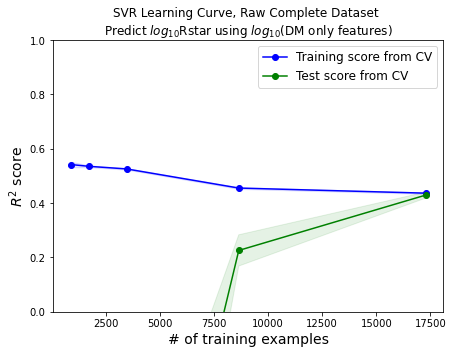

In [32]:
# this code takes ~2.5min to run on the whole dataset with ~22,000 galaxies
start_time = time.time()

lc_all_dm = plot_learning_curve(best_SVR_dm, 'SVR Learning Curve, Raw Complete Dataset \n'+r'Predict $log_{10}$Rstar using $log_{10}$(DM only features)', X_dm, y_dm, ylim=(0.0, 1.0), train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset w DM only features: {elapsed_time:.3f} seconds")

# lc_all_dm.savefig('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_wDMfeatures_SVR_Learning_Curve.jpeg', dpi=500)

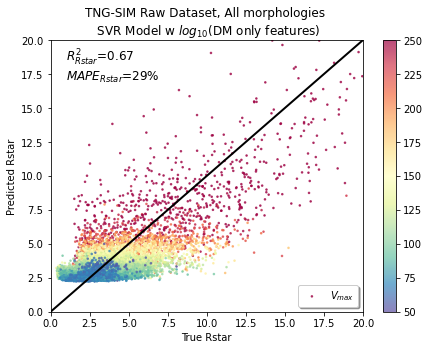

In [34]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_SVR_dm),
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$', vmin=50, vmax=250)
ax.text(1.0, 17, r'$R^{2}_{Rstar}$=0.67' + '\n' + r'$MAPE_{Rstar}$=29$\%$ ', size=12)
ax.axis([0.0,20, 0.0,20])
ax.plot([0, 30], [0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, All morphologies \n ' + r'SVR Model w $log_{10}$(DM only features) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_wDMfeatures_SVR_size_pred_colorVmaxVvir_2.jpeg', dpi=500)
plt.show()

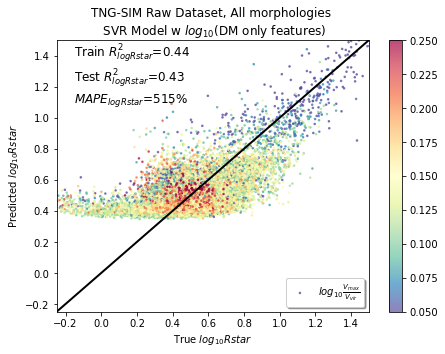

In [36]:
# Plot of Predicted log10 Raw Rstar vs True log 10 Raw Rstar

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw_log.SubhaloRstar_log, y_pred_SVR_dm,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-0.15, 1.1, r'Train $R^{2}_{logRstar}$=0.44' + '\n' + r'Test $R^{2}_{logRstar}$=0.43' + '\n' + r'$MAPE_{logRstar}$=515$\%$ ', size=12)
ax.axis([-0.25,1.5, -0.25,1.5])
ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, All morphologies \n ' + r'SVR Model w $log_{10}$(DM only features) ')
ax.set_xlabel(r'True $log_{10}Rstar$')
ax.set_ylabel(r'Predicted $log_{10}Rstar$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_wDMfeatures_SVR_size_pred_colorlogVmaxVvir_1.jpeg', dpi=500)
plt.show()